# miχpods for LES simulations


## Build Catalog

Using ecgtools

Dan:
> (100 W is grid point “1402” and 165 W is grid point “102”; 140W is “602” first date
“25MAY1985” indicates first simulated date; second date 24NOV2021 is the nominal date I started the runs):

In [ ]:
import glob
import pathlib

import ecgtools
import intake
import intake_esm
import xarray as xr

In [ ]:
root = (
    "/glade/p/cgd/oce/people/dwhitt/TPOS/"
    "tpos_LES_runs_setup_scripts/tpos-DIABLO/diablo_2.0/post_process/diablo_analysis"
)

In [ ]:
def parse_les_file(path):
    path = pathlib.Path(path)
    split = path.stem.split("_")
          
    # print(split)
    # print(path)
    
    if split[3] == "242":
        length = "5-day"
        kind = "average"
        longitude = int(-165 + (int(split[4]) - 102)* 0.05)
        latitude = 0
    else:
        length = "month"
        kind = "mooring" if "mooring" in split[-1] else "average"
        longitude = int(split[3][-4:-1])
        latitude = float(split[3][:-5]) * (-1 if "S" in split[3] else 1)

    with xr.open_dataset(path) as ds:
        info = {
            "length": length,
            "kind": kind,
            "longitude": longitude,
            "latitude": latitude,
            "month": "may" if "MAY" in split[-2] else "oct",
            "path": path,
            "variables": [k for k in ds],

        }
    return info

parse_les_file(f"{root}/ROMS_PSH_6HRLIN_0N140W_360x360x216_22OCT2020.nc")


{'length': 'month',
 'kind': 'average',
 'longitude': 140,
 'latitude': 0.0,
 'month': 'oct',
 'path': PosixPath('/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_runs_setup_scripts/tpos-DIABLO/diablo_2.0/post_process/diablo_analysis/ROMS_PSH_6HRLIN_0N140W_360x360x216_22OCT2020.nc'),
 'variables': ['ume',
  'vme',
  'tempme',
  'saltme',
  'urms',
  'vrms',
  'wrms',
  'temprms',
  'saltrms',
  'uw',
  'vw',
  'saltw',
  'tempw',
  'nududz',
  'nudvdz',
  'kappadsdz',
  'kappadtdz',
  'dTdtSOLAR',
  'dTdtRESTORE',
  'dTdtFORCE',
  'dUdtRESTORE',
  'dUdtFORCE',
  'dVdtRESTORE',
  'dVdtFORCE',
  'epsilon',
  'N2',
  'S2',
  'RIG',
  'nududztop',
  'nudvdztop',
  'kappadsdztop',
  'kappadtdztop',
  'nududzbot',
  'nudvdzbot',
  'kappadsdzbot',
  'kappadtdzbot',
  'alpha',
  'beta',
  'T0',
  'S0',
  'rho0']}

In [ ]:
builder = ecgtools.Builder(
    root, 
    exclude_patterns=[
        "*test*", 
        "*irene_*", 
        "*spectra*", 
        "*fixedeps*", 
        "*timeavg*", 
        "*0N140W*5OCT202*", 
        "*0N140W*20OCT202*", 
        "*0N140W*29OCT202*", 
        "*6mavg*",
        "*54x54*",
    ], 
    njobs=-1,
)
builder.build(parse_les_file)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   21.4s finished


Builder(root_path=PosixPath('/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_runs_setup_scripts/tpos-DIABLO/diablo_2.0/post_process/diablo_analysis'), extension='.nc', depth=0, exclude_patterns=['*test*', '*irene_*', '*spectra*', '*fixedeps*', '*timeavg*', '*0N140W*5OCT202*', '*0N140W*20OCT202*', '*0N140W*29OCT202*', '*6mavg*', '*54x54*'], njobs=-1)

### Summarize catalog

In [ ]:
builder.df.groupby(["length", "kind", "latitude", "longitude", "month"]).count()

path  variables
length kind    latitude longitude month                 
5-day  average  0.0     -165      may       1          1
                                  oct       1          1
                        -160      may       1          1
                                  oct       1          1
                        -155      may       1          1
                                  oct       1          1
                        -150      may       1          1
                                  oct       1          1
                        -145      may       1          1
                                  oct       1          1
                        -140      may       1          1
                        -135      may       1          1
                                  oct       1          1
                        -130      may       1          1
                                  oct       1          1
                        -125      may       1          1
                                  oct       1          1
                        -120      may       1          1
                                  oct       1          1
                        -115      may       1          1
                                  oct       1          1
                        -110      may       1          1
                                  oct       1          1
                        -105      may       1          1
                                  oct       1          1
                        -100      may       1          1
                                  oct       1          1
month  average -1.5      140      oct       1          1
                0.0      140      oct       1          1
                1.5      140      oct       1          1
                3.0      140      oct       1          1
                4.5      140      oct       1          1
       mooring -1.5      140      oct       1          1
                0.0      140      oct       1          1
                1.5      140      oct       1          1
                4.5      140      oct       1          1

In [ ]:
builder.save(
    "../catalogs/pump-les-catalog.csv",
    path_column_name="path",
    variable_column_name="variables",
    data_format="netcdf",
    groupby_attrs=["longitude", "month"],
    aggregations=[
        {'type': 'union', 'attribute_name': 'variables'},
        {
            'type': 'join_new',
            'attribute_name': 'longitude',
            'options': {'coords': 'minimal', 'compat': 'override'},
        },
        {
            'type': 'join_new',
            'attribute_name': 'month',
            'options': {'coords': 'minimal', 'compat': 'override'},
        },
        {
            'type': 'join_new',
            'attribute_name': 'kind',
            'options': {'coords': 'minimal', 'compat': 'override'},
        },
        {
            'type': 'length',
            'attribute_name': 'kind',
            'options': {'coords': 'minimal', 'compat': 'override'},
        },
    ]
)

Saved catalog location: ../catalogs/pump-les-catalog.json and ../catalogs/pump-les-catalog.csv


In [ ]:
import ast
from datatree import DataTree

catalog = intake.open_esm_datastore(
    "../catalogs/pump-les-catalog.json", 
    csv_kwargs={"converters": {"variables": ast.literal_eval}},
)
catalog.df

,length,kind,longitude,latitude,month,path,variables
0,5-day,average,-120,0.0,may,/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_r...,"(ume, vme, tempme, saltme, urms, vrms, wrms, t..."
1,5-day,average,-165,0.0,may,/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_r...,"(ume, vme, tempme, saltme, urms, vrms, wrms, t..."
2,5-day,average,-115,0.0,may,/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_r...,"(ume, vme, tempme, saltme, urms, vrms, wrms, t..."
3,5-day,average,-110,0.0,may,/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_r...,"(ume, vme, tempme, saltme, urms, vrms, wrms, t..."
4,5-day,average,-105,0.0,may,/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_r...,"(ume, vme, tempme, saltme, urms, vrms, wrms, t..."
5,5-day,average,-100,0.0,may,/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_r...,"(ume, vme, tempme, saltme, urms, vrms, wrms, t..."
6,5-day,average,-160,0.0,may,/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_r...,"(ume, vme, tempme, saltme, urms, vrms, wrms, t..."
7,5-day,average,-155,0.0,may,/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_r...,"(ume, vme, tempme, saltme, urms, vrms, wrms, t..."
8,5-day,average,-150,0.0,may,/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_r...,"(ume, vme, tempme, saltme, urms, vrms, wrms, t..."
9,5-day,average,-145,0.0,may,/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_r...,"(ume, vme, tempme, saltme, urms, vrms, wrms, t..."


In [ ]:
dataset_dict = catalog.to_dataset_dict(cdf_kwargs={})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'longitude.month'


In [ ]:
tree = DataTree.from_dict(dataset_dict)

In [ ]:
tree["-140.may"].ds

<xarray.Dataset>
Dimensions:       (z: 288, time: 1313, longitude: 1, month: 1)
Coordinates:
  * z             (z) float64 -143.5 -143.0 -142.5 ... -1.0 -0.5 9.969e+36
  * time          (time) datetime64[ns] 1985-05-25T03:00:00 ... 1985-05-30T00...
  * month         (month) <U3 'may'
  * longitude     (longitude) int64 -140
Data variables: (12/41)
    ume           (longitude, month, time, z) float32 dask.array<chunksize=(1, 1, 1313, 288), meta=np.ndarray>
    vme           (longitude, month, time, z) float32 dask.array<chunksize=(1, 1, 1313, 288), meta=np.ndarray>
    tempme        (longitude, month, time, z) float32 dask.array<chunksize=(1, 1, 1313, 288), meta=np.ndarray>
    saltme        (longitude, month, time, z) float32 dask.array<chunksize=(1, 1, 1313, 288), meta=np.ndarray>
    urms          (longitude, month, time, z) float32 dask.array<chunksize=(1, 1, 1313, 288), meta=np.ndarray>
    vrms          (longitude, month, time, z) float32 dask.array<chunksize=(1, 1, 1313, 288), meta=np.ndarray>
    ...            ...
    kappadtdzbot  (longitude, month, time) float32 dask.array<chunksize=(1, 1, 1313), meta=np.ndarray>
    alpha         (longitude, month) float64 0.0002976
    beta          (longitude, month) float64 -0.0007386
    T0            (longitude, month) float64 25.0
    S0            (longitude, month) float64 35.25
    rho0          (longitude, month) float64 1.024e+03
Attributes:
    type:                    DIABLO LES, processed means
    title:                   ROMS_PSH_6HRLIN_0N140W_360x360x288_5OCT2021
    history:                 Tue Dec 28 09:09:16 2021: ncatted -O -a units,ti...
    NCO:                     netCDF Operators version 4.9.5 (Homepage = http:...
    intake_esm_varname:      ('ume', 'vme', 'tempme', 'saltme', 'urms', 'vrms...
    intake_esm_dataset_key:  -140.may

In [ ]:
may = pump.les.read_les_file(
    "../datasets/les_post_process/ROMS_PSH_3HRLIN_242_602_360x360x288_25MAY1985_24NOV2021.nc"
)
may

<xarray.Dataset>
Dimensions:       (z: 288, time: 1313)
Coordinates:
  * z             (z) float64 -143.5 -143.0 -142.5 -142.0 ... -1.5 -1.0 -0.5 0.0
  * time          (time) datetime64[ns] 1985-05-25T03:00:00 ... 1985-05-30T00...
    alpha         float64 ...
    beta          float64 ...
    T0            float64 ...
    S0            float64 ...
    dz            float64 0.5
Data variables: (12/67)
    ume           (time, z) float32 ...
    vme           (time, z) float32 ...
    tempme        (time, z) float32 ...
    saltme        (time, z) float32 ...
    urms          (time, z) float32 ...
    vrms          (time, z) float32 ...
    ...            ...
    chi           (time, z) float32 2.227e-08 -2.505e-10 ... 1.66e-08 nan
    tke           (time, z) float32 4.914e-12 4.067e-12 ... 0.0003075 nan
    Rif           (time, z) float64 nan nan nan nan nan ... nan nan nan nan nan
    Reb           (time, z) float32 nan 0.01892 0.01975 0.02009 ... nan nan nan
    Jq            (time, z) float64 -31.12 0.3899 0.3944 ... -23.48 -117.2 nan
    eucmax        (time) float64 -95.0 -95.0 -95.0 -95.0 ... -92.5 -92.5 -92.5
Attributes:
    type:     DIABLO LES, processed means
    title:    ROMS_PSH_6HRLIN_0N140W_360x360x288_5OCT2021
    history:  Tue Dec 28 09:09:16 2021: ncatted -O -a units,time,m,c,seconds ...
    NCO:      netCDF Operators version 4.9.5 (Homepage = http://nco.sf.net, C...

In [ ]:
octo = pump.les.read_les_file(
    "../datasets/les_post_process/ROMS_PSH_6HRLIN_0N140W_360x360x216_22OCT2020.nc"
)
octo

<xarray.Dataset>
Dimensions:       (z: 216, time: 8774)
Coordinates:
  * z             (z) float64 -107.5 -107.0 -106.5 -106.0 ... -1.5 -1.0 -0.5 0.0
  * time          (time) datetime64[ns] 1985-10-02T06:00:00 ... 1985-11-05T20...
    alpha         float64 ...
    beta          float64 ...
    T0            float64 ...
    S0            float64 ...
    dz            float64 0.5
Data variables: (12/67)
    ume           (time, z) float32 ...
    vme           (time, z) float32 ...
    tempme        (time, z) float32 ...
    saltme        (time, z) float32 ...
    urms          (time, z) float32 ...
    vrms          (time, z) float32 ...
    ...            ...
    chi           (time, z) float32 1.062e-08 -6.989e-10 ... -2.423e-07 nan
    tke           (time, z) float32 4.914e-08 4.067e-08 ... 0.0001316 nan
    Rif           (time, z) float64 nan nan nan nan nan ... nan nan nan nan nan
    Reb           (time, z) float32 nan 8.843 9.495 9.885 ... nan nan nan nan
    Jq            (time, z) float64 -11.26 0.6191 0.5909 ... -12.06 -79.09 nan
    eucmax        (time) float64 nan nan nan nan ... -104.0 -104.0 -104.0 -104.0
Attributes:
    type:     DIABLO LES, processed means
    title:    ROMS_PSH_6HRLIN_0N140W_360x360x216_22OCT2020

In [ ]:
may["n2s2pdf"] = mixpods.pdf_N2S2(may)
octo["n2s2pdf"] = mixpods.pdf_N2S2(octo)

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


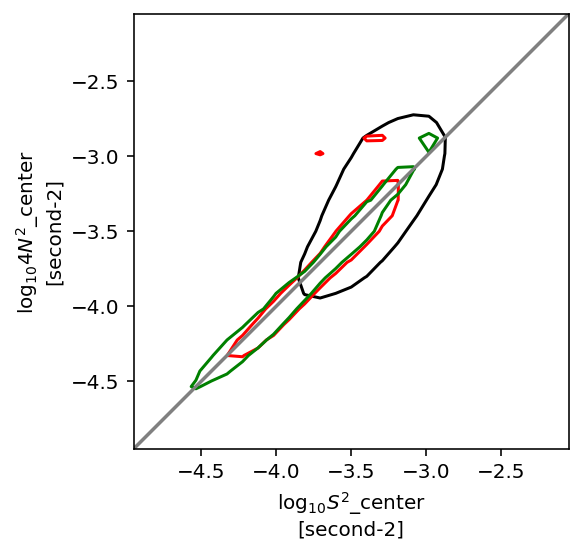

In [ ]:
for ds, color in zip([tao_gridded, octo, may], ["k", "r", "g"]):
    plot_n2s2pdf(ds.n2s2pdf.sel(enso_transition_phase="none"),  colors=color, targets=0.5, pcolor=False)